# First steps in Tensorflow

Trying eager execution for a 1D regression problem

# Prerequisites

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
tf.enable_eager_execution()
tf.random.set_random_seed(0)

print(tf.__version__)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [2]:
xmin = 0.01
xmax = 1
xres = 100
x = tf.linspace(xmin, xmax, xres)

In [3]:
y = tf.math.polyval([0., 2., 5.], x) + tf.math.sin(8*x) + .3 * tf.random.normal([xres])

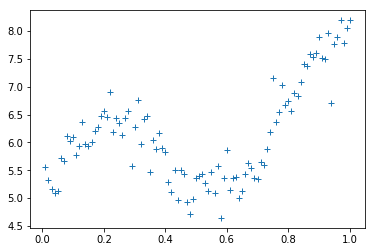

In [4]:
plt.plot(x, y, "+")

# Training Tensorflow models

In [22]:
EPOCHS = 1000 #2500
lr = 1e-4
w_dim = 256

In [13]:
def compile_model(model, learning_rate):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss = tf.losses.mean_squared_error

    model.compile(loss=[loss],
                  optimizer=optimizer,
                  metrics=['mae'])
    
    return model

In [69]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % int(EPOCHS / 5) == 0: print(f'{int(epoch / int(EPOCHS / 5))}/5th')
            
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    PrintDot()
]

In [70]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

## Keras training - Sequential API

PS : I have no idea why I need to convert x to numpy when using `validation_split` because otherwise I get:

```
-> 1581         split_at = int(x[0].shape[0] * (1. - validation_split))
   1582       else:
   1583         split_at = int(len(x[0]) * (1. - validation_split))

TypeError: unsupported operand type(s) for *: 'Dimension' and 'float'
```

In [59]:
def build_sequential_model(w, learning_rate):
    model = keras.Sequential([
        keras.layers.Dense(w, activation=tf.nn.relu, input_shape=(1, )),
        keras.layers.Dense(1)
    ])
    
    return compile_model(model, learning_rate)

In [71]:
model_sequential = build_sequential_model(w_dim, lr)
history_sequential = model_sequential.fit(x.numpy(), y, epochs=EPOCHS,
                                          validation_split=0.2,
                                          verbose=0,
                                          callbacks=callbacks,
                                         )

0/5th
1/5th
2/5th
3/5th
4/5th


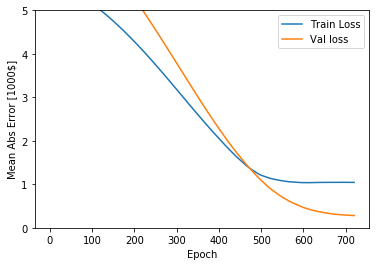

In [67]:
plot_history(history_sequential)

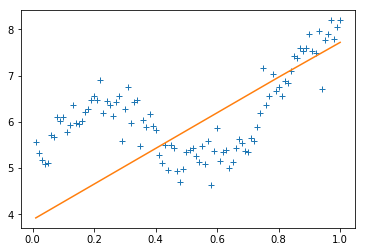

In [62]:
plt.plot(x, y, "+", x, model_sequential.predict(x))

## Keras training - subclassing Model class

In [63]:
class LinModel(tf.keras.Model):

    def __init__(self, w):
        super(LinModel, self).__init__()
        self.dense1 = keras.layers.Dense(w, activation=tf.nn.relu, input_shape=(1, )),
        self.dense2 = keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

In [65]:
model_class = compile_model(LinModel(w_dim), lr)
history_class = model_class.fit(x.numpy(), y, epochs=EPOCHS,
                                validation_split=0.2,
                                verbose=0,
                                callbacks=[PrintDot()])

TypeError: 'tuple' object is not callable

## TF Estimator